In [10]:
import numpy as np

import glob

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from netCDF4 import Dataset

from wrf import getvar, to_np, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords, ALL_TIMES, interp1d
import wrf

import metpy.calc as mpcalc
from metpy.units import units

from datetime import datetime, timedelta

import pandas as pd

In [11]:
max_alt = 6000 #m

#sounding directory
sounding_dir = "./Deployments/NorthDakota_Annular_Eclipse/"

#get list of sounding files
files = []
dirs = glob.glob(sounding_dir+"PCCC*")
for this_dir in dirs:
    this_file = glob.glob(this_dir+"/*_profile.txt")
    if len(this_file)>0:
        files.append(this_file[0])
        
#open each sounding in pandas
#pop the first one from the list
this_file = files.pop(0)
this_date = this_file[-24:-18]
soundings = pd.read_csv(this_file,encoding='ISO-8859-1',sep='\t')
soundings = soundings.rename(columns=lambda x: x.strip())
#drop everything after balloon reaches max altitude defined above
top_idx = soundings[soundings['Geopot [m]']>max_alt].index[0]
soundings = soundings.drop(soundings.index[top_idx:])
#get date & times
time_strs = soundings['Time (UTC)'].values
time_arr = np.empty(len(time_strs),dtype=pd.Timestamp)
for i in range(len(time_strs)):
    dt_str = this_date+' '+time_strs[i].strip()
    dt = datetime.strptime(dt_str,"%d%m%y %H:%M:%S")
    dt = dt-timedelta(hours=6)
    time_arr[i] = pd.Timestamp(dt)#.to_numpy()
soundings['TIMESTAMP']=time_arr

#now read all the others and append
for file in files:
    this_date = file[-24:-18]
    this_sounding = pd.read_csv(file,encoding='ISO-8859-1',sep='\t')
    this_sounding = this_sounding.rename(columns=lambda x: x.strip())
    #drop everything after balloon reaches max altitude defined above
    top_idx = this_sounding[this_sounding['Geopot [m]']>max_alt].index[0]
    this_sounding = this_sounding.drop(this_sounding.index[top_idx:])
    #get date & times
    time_strs = this_sounding['Time (UTC)'].values
    time_arr = np.empty(len(time_strs),dtype=pd.Timestamp)
    for i in range(len(time_strs)):
        dt_str = this_date+' '+time_strs[i].strip()
        dt = datetime.strptime(dt_str,"%d%m%y %H:%M:%S")
        dt = dt-timedelta(hours=6)
        time_arr[i] = pd.Timestamp(dt)#.to_numpy()
    #handle special situation at 00Z launch
    if "PCCC9" in file:
        days = np.array([i.day for i in time_arr])
        inds=np.where(days==14)
        time_arr[inds] = time_arr[inds]-timedelta(days=1)
    this_sounding['TIMESTAMP']=time_arr
    #merge at end
    soundings = pd.concat([soundings,this_sounding])

soundings = soundings.sort_values(by='TIMESTAMP',ascending=True)
soundings.reset_index(inplace=True)

#get data on 14th
first_idx = soundings[soundings['TIMESTAMP'].dt.day==14].index[0]
soundings_14 = soundings.drop(soundings.index[:first_idx])
soundings_13 = soundings.drop(soundings.index[first_idx:])

In [12]:
#get data in lowest 1500m
soundings = soundings_14
soundings = soundings.drop(soundings[soundings['Alt [m]']>(2026+1500)].index)
#get time of launch hour (just round to nearest hour)
launch_time = np.zeros(len(soundings))
for i in range(len(soundings)):
    this_time = soundings['TIMESTAMP'].iloc[i]
    this_time = this_time.replace(second=0,minute=0,hour=this_time.hour)+timedelta(hours=this_time.minute//30)
    launch_time[i] = this_time.hour #+ 24*(this_time.day-14)

alts=soundings['Alt [m]'].values
ws=soundings['Ws [m/s]'].values * units('m/s')
wd=soundings['Wd [°]'].values * units('degrees')

#calculate altitude where wind shift occurs
launches = np.unique(launch_time)
shift_alt = np.zeros(len(launches))
for i in range(len(shift_alt)):
    this_inds = np.where(launch_time==launches[i])
    this_alt = alts[this_inds]
    this_wd = wd[this_inds]
    this_ws = ws[this_inds].to('knots')
    abv_ind = np.where((this_wd.magnitude>=180) & (this_ws.magnitude>=3.0))[0]
    if len(abv_ind)==0:
        abv_ind=0
    else:
        abv_ind=abv_ind[0]
    blw_ind = np.where((this_wd.magnitude<=180) & (this_ws.magnitude>=3.0))[0]
    if len(blw_ind)==0:
        blw_ind=0
    else:
        if np.amin(blw_ind)>abv_ind:
            blw_ind=0
            abv_ind=0
        else:
            blw_ind = blw_ind[np.where(blw_ind<abv_ind)[0][-1]]
        #blw_ind=blw_ind[-1]
    shift_alt[i] = (this_alt[blw_ind]+this_alt[abv_ind])/2
    
u,v = mpcalc.wind_components(ws,wd)
u = u.to('knots')
#u[ws.to('knots').magnitude<3.0] = np.nan
v = v.to('knots')
#v[ws.to('knots').magnitude<3.0] = np.nan

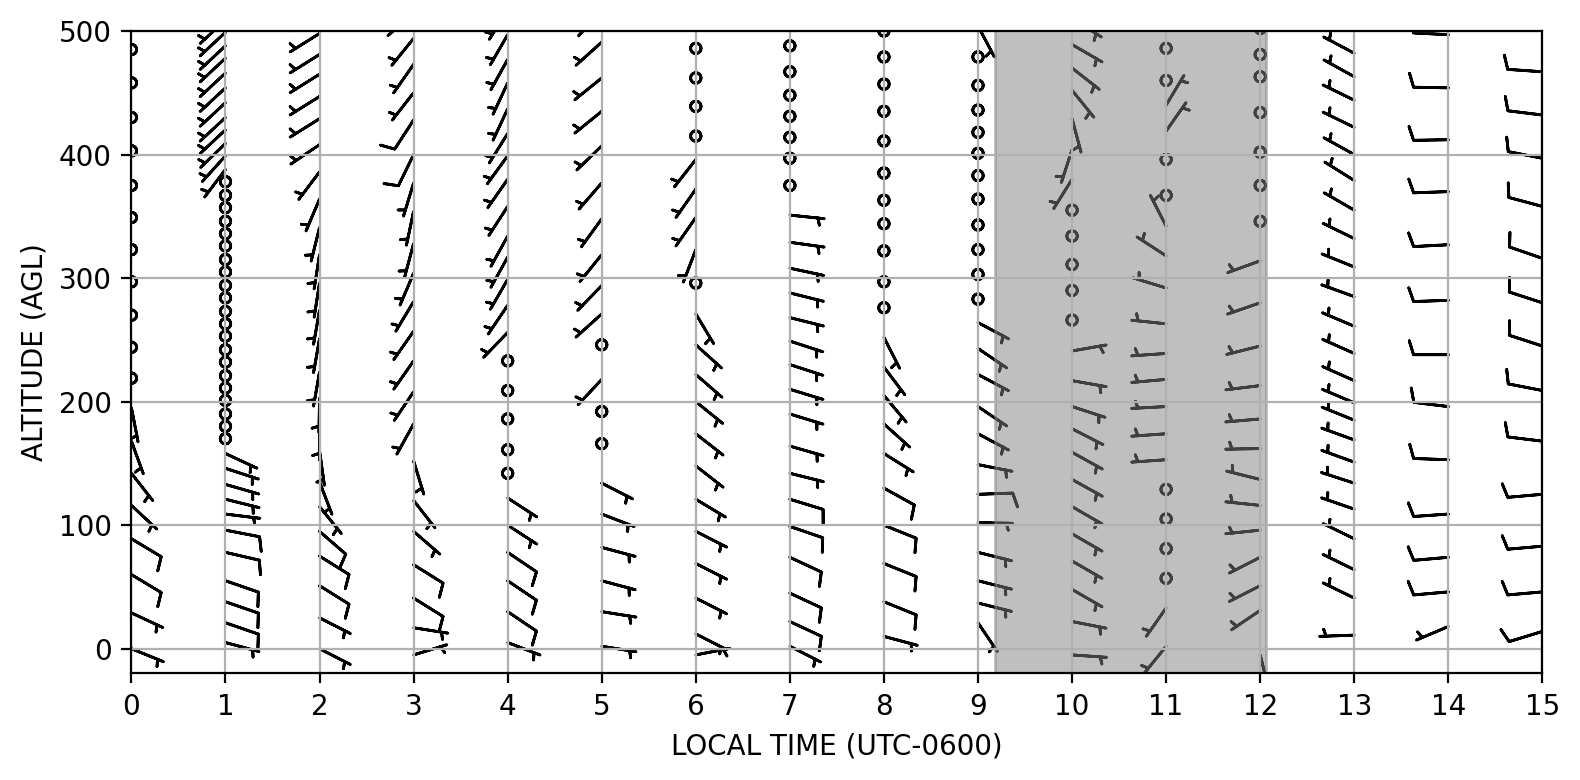

In [13]:
sfc_alt = 2026
skip = 5
fig = plt.figure(figsize=(8,4),dpi=200)
ax = plt.subplot(1,1,1)
ax.barbs(launch_time[::skip],(alts-sfc_alt)[::skip],u[::skip],v[::skip],length=5)
ax.axvspan(9.18,12.06,0,360,color='gray',alpha=0.5)
#plt.plot(launches,shift_alt-sfc_alt,color='k')
plt.ylim([-20,500])
ax.set_xticks(range(16))
plt.xlim([0,15])
plt.xlabel('LOCAL TIME (UTC-0600)')
plt.ylabel('ALTITUDE (AGL)')
plt.grid()
#xticks = np.array(ax.get_xticks())
#xticks[xticks<0] = 24 + xticks[xticks<0]
#ax.set_xticklabels(xticks.astype(int))
fig.tight_layout()

plt.savefig("soundings_14.png",bbox_inches='tight')

In [14]:
#get data in lowest 1500m
soundings = soundings_13
soundings = soundings.drop(soundings[soundings['Alt [m]']>(2026+1500)].index)
#get time of launch hour (just round to nearest hour)
launch_time = np.zeros(len(soundings))
for i in range(len(soundings)):
    this_time = soundings['TIMESTAMP'].iloc[i]
    this_time = this_time.replace(second=0,minute=0,hour=this_time.hour)+timedelta(hours=this_time.minute//30)
    launch_time[i] = this_time.hour #+ 24*(this_time.day-14)

alts=soundings['Alt [m]'].values
ws=soundings['Ws [m/s]'].values * units('m/s')
wd=soundings['Wd [°]'].values * units('degrees')

#calculate altitude where wind shift occurs
launches = np.unique(launch_time)
shift_alt = np.zeros(len(launches))
for i in range(len(shift_alt)):
    this_inds = np.where(launch_time==launches[i])
    this_alt = alts[this_inds]
    this_wd = wd[this_inds]
    this_ws = ws[this_inds].to('knots')
    abv_ind = np.where((this_wd.magnitude>=180) & (this_ws.magnitude>=3.0))[0]
    if len(abv_ind)==0:
        abv_ind=0
    else:
        abv_ind=abv_ind[0]
    blw_ind = np.where((this_wd.magnitude<=180) & (this_ws.magnitude>=3.0))[0]
    if len(blw_ind)==0:
        blw_ind=0
    else:
        if np.amin(blw_ind)>abv_ind:
            blw_ind=0
            abv_ind=0
        else:
            blw_ind = blw_ind[np.where(blw_ind<abv_ind)[0][-1]]
        #blw_ind=blw_ind[-1]
    shift_alt[i] = (this_alt[blw_ind]+this_alt[abv_ind])/2
    
u,v = mpcalc.wind_components(ws,wd)
u = u.to('knots')
#u[ws.to('knots').magnitude<3.0] = np.nan
v = v.to('knots')
#v[ws.to('knots').magnitude<3.0] = np.nan

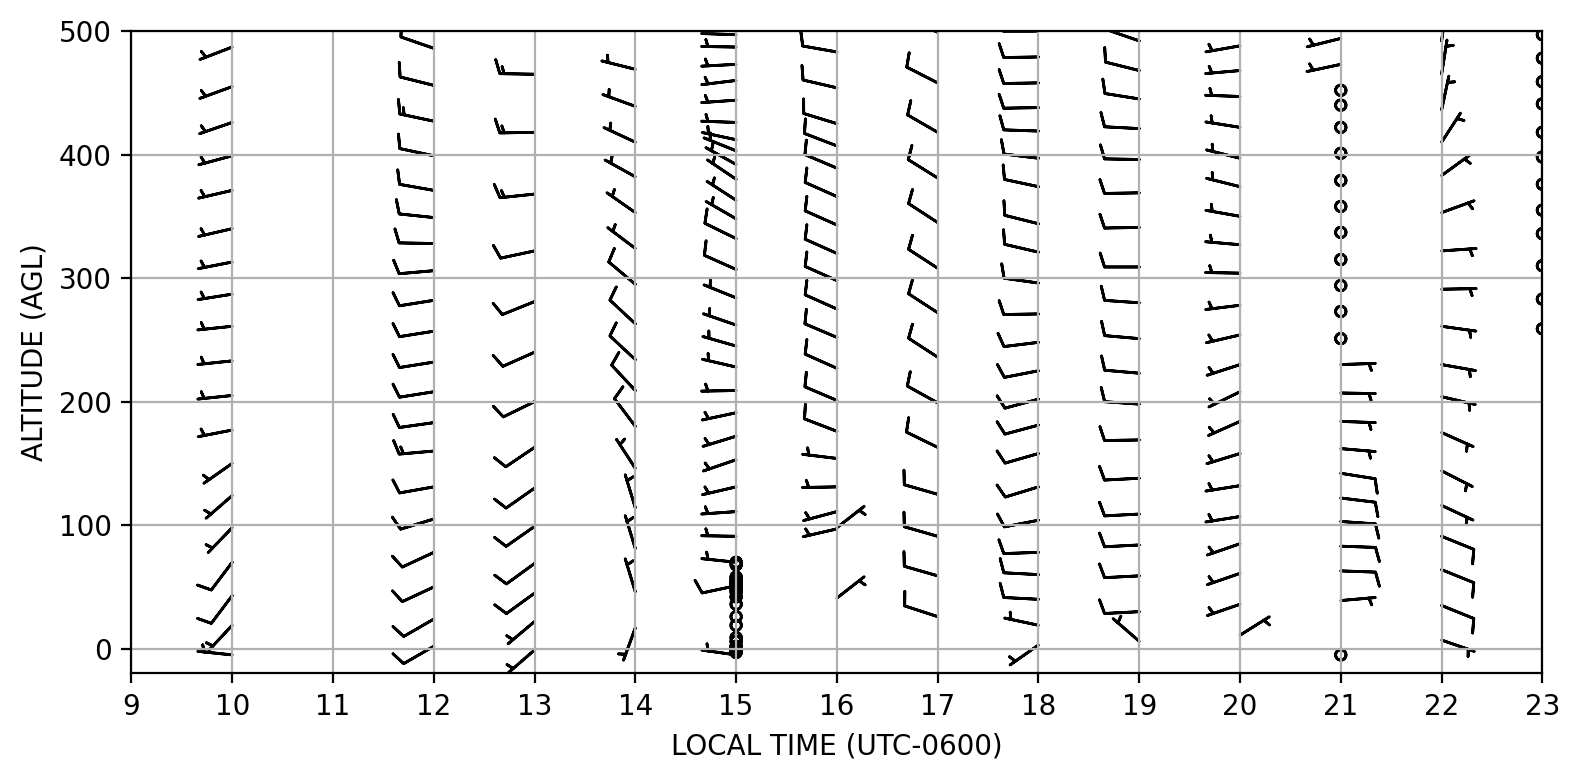

In [15]:
sfc_alt = 2026
skip = 5
fig = plt.figure(figsize=(8,4),dpi=200)
ax = plt.subplot(1,1,1)
ax.barbs(launch_time[::skip],(alts-sfc_alt)[::skip],u[::skip],v[::skip],length=5)
#ax.axvspan(9.18,12.06,0,360,color='gray',alpha=0.5)
#plt.plot(launches,shift_alt-sfc_alt,color='k')
plt.ylim([-20,500])
ax.set_xticks(range(9,24))
plt.xlim([9,23])
plt.xlabel('LOCAL TIME (UTC-0600)')
plt.ylabel('ALTITUDE (AGL)')
plt.grid()
#xticks = np.array(ax.get_xticks())
#xticks[xticks<0] = 24 + xticks[xticks<0]
#ax.set_xticklabels(xticks.astype(int))
fig.tight_layout()
plt.savefig("soundings_13.png",bbox_inches='tight')

In [18]:
### Now do model
d03_fname = "wrfout_d03_2023-10-11_00:00:00"

eclipse_dir = "./eclipse"
no_eclipse_dir = "./no_eclipse"

nc_eclipse_d03 = Dataset(eclipse_dir+"/"+d03_fname)
nc_no_eclipse_d03 = Dataset(no_eclipse_dir+"/"+d03_fname)

pccc_lon = -108.43834
pccc_lat = 37.35477

ue,ve = wrf.getvar(nc_eclipse_d03,"uvmet",timeidx=ALL_TIMES,units="kts")
une,vne = wrf.getvar(nc_no_eclipse_d03,"uvmet",timeidx=ALL_TIMES,units="kts")
ze = wrf.getvar(nc_eclipse_d03,"z",timeidx=ALL_TIMES,units="m")
zne = wrf.getvar(nc_no_eclipse_d03,"z",timeidx=ALL_TIMES,units="m")
hgt = wrf.getvar(nc_eclipse_d03,'HGT',timeidx=0)


times = getvar(nc_eclipse_d03,"Times",timeidx=ALL_TIMES)

lats, lons = latlon_coords(ze)
cart_proj = get_cartopy(ze)

In [19]:
bl_index = np.where((lons.values<=pccc_lon) & (lats.values<=pccc_lat))
bl_i = bl_index[0][-1]
bl_j = bl_index[1][-1]

frac_ind_i = (pccc_lat - lats.values[bl_i,bl_j]) / (lats.values[bl_i+1,bl_j+1] - lats.values[bl_i,bl_j])
frac_ind_j = (pccc_lon - lons.values[bl_i,bl_j]) / (lons.values[bl_i+1,bl_j+1] - lons.values[bl_i,bl_j])

ze_pcc = np.empty((len(ze),len(ze[0])))
ue_pcc = np.empty((len(ze),len(ze[0])))
ve_pcc = np.empty((len(ze),len(ze[0])))
zne_pcc = np.empty((len(ze),len(ze[0])))
une_pcc = np.empty((len(ze),len(ze[0])))
vne_pcc = np.empty((len(ze),len(ze[0])))
hgt_pcc = 0

x_mat = np.matrix([1-frac_ind_i, frac_ind_i])
y_mat = np.matrix([[1-frac_ind_j],[frac_ind_j]])

f00 = hgt[bl_i,bl_j]
f01 = hgt[bl_i,bl_j+1]
f10 = hgt[bl_i+1,bl_j]
f11 = hgt[bl_i+1,bl_j+1]
f_mat = np.matrix([[f00, f01], [f10, f11]])
hgt_pcc = (x_mat*f_mat*y_mat).item()

for i in range(len(ze_pcc)):
    for j in range(len(ze_pcc[i])):

        
        #ECLIPSE
        #z
        f00 = ze[i,j][bl_i,bl_j]
        f01 = ze[i,j][bl_i,bl_j+1]
        f10 = ze[i,j][bl_i+1,bl_j]
        f11 = ze[i,j][bl_i+1,bl_j+1]
        f_mat = np.matrix([[f00, f01], [f10, f11]])
        ze_pcc[i,j] = (x_mat*f_mat*y_mat).item()
        #u
        f00 = ue[i,j][bl_i,bl_j]
        f01 = ue[i,j][bl_i,bl_j+1]
        f10 = ue[i,j][bl_i+1,bl_j]
        f11 = ue[i,j][bl_i+1,bl_j+1]
        f_mat = np.matrix([[f00, f01], [f10, f11]])
        ue_pcc[i,j] = (x_mat*f_mat*y_mat).item()
        #v
        f00 = ve[i,j][bl_i,bl_j]
        f01 = ve[i,j][bl_i,bl_j+1]
        f10 = ve[i,j][bl_i+1,bl_j]
        f11 = ve[i,j][bl_i+1,bl_j+1]
        f_mat = np.matrix([[f00, f01], [f10, f11]])
        ve_pcc[i,j] = (x_mat*f_mat*y_mat).item()
        
        #NO ECLIPSE
        #z
        f00 = zne[i,j][bl_i,bl_j]
        f01 = zne[i,j][bl_i,bl_j+1]
        f10 = zne[i,j][bl_i+1,bl_j]
        f11 = zne[i,j][bl_i+1,bl_j+1]
        f_mat = np.matrix([[f00, f01], [f10, f11]])
        zne_pcc[i,j] = (x_mat*f_mat*y_mat).item()
        #u
        f00 = une[i,j][bl_i,bl_j]
        f01 = une[i,j][bl_i,bl_j+1]
        f10 = une[i,j][bl_i+1,bl_j]
        f11 = une[i,j][bl_i+1,bl_j+1]
        f_mat = np.matrix([[f00, f01], [f10, f11]])
        une_pcc[i,j] = (x_mat*f_mat*y_mat).item()
        #v
        f00 = vne[i,j][bl_i,bl_j]
        f01 = vne[i,j][bl_i,bl_j+1]
        f10 = vne[i,j][bl_i+1,bl_j]
        f11 = vne[i,j][bl_i+1,bl_j+1]
        f_mat = np.matrix([[f00, f01], [f10, f11]])
        vne_pcc[i,j] = (x_mat*f_mat*y_mat).item()

times = getvar(nc_eclipse_d03,"Times",timeidx=ALL_TIMES)
dates = pd.DatetimeIndex(times) - timedelta(hours=6)
inds = np.where(dates.day == 14)
dates = dates[inds]
hours = np.array(dates.hour + dates.minute/60)
hours = np.repeat(hours[:, np.newaxis], len(ze_pcc[0]), axis=1)

In [20]:
#calculate altitude where wind shift occurs
launches = hours[:,0]
print(launches.shape)
shift_alt_e = np.zeros(len(launches))
shift_alt_ne = np.zeros(len(launches))
for i in range(len(shift_alt_e)):
    this_ze = ze_pcc[inds][i]
    this_zne = zne_pcc[inds][i]
    this_ue = ue_pcc[inds][i]
    this_ve = ve_pcc[inds][i]
    this_une = une_pcc[inds][i]
    this_vne = vne_pcc[inds][i]
    this_wd_e = mpcalc.wind_direction(this_ue*units('knots'),this_ve*units('knots'))
    this_ws_e = np.sqrt(ve_pcc[inds][i]**2 + ue_pcc[inds][i]**2)
    this_wd_ne = mpcalc.wind_direction(this_une*units('knots'),this_vne*units('knots'))
    this_ws_ne = np.sqrt(ve_pcc[inds][i]**2 + ue_pcc[inds][i]**2)
    
    abv_ind_e = np.where((this_wd_e.magnitude>=180) & (this_ws_e>=3.0))[0]
    if len(abv_ind_e)==0:
        abv_ind_e=0
    else:
        abv_ind_e=abv_ind_e[0]
        
    abv_ind_ne = np.where((this_wd_ne.magnitude>=180) & (this_ws_ne>=3.0))[0]
    if len(abv_ind_ne)==0:
        abv_ind_e=0
    else:
        abv_ind_ne=abv_ind_ne[0]
        
    blw_ind_e = np.where((this_wd_e.magnitude<=180) & (this_ws_e>=3.0))[0]
    if len(blw_ind_e)==0:
        blw_ind_e=0
    else:
        if np.amin(blw_ind_e)>abv_ind_e:
            blw_ind_e=0
            abv_ind_e=0
        else:
            blw_ind_e = blw_ind_e[np.where(blw_ind_e<abv_ind_e)[0][-1]]
            
    blw_ind_ne = np.where((this_wd_ne.magnitude<=180) & (this_ws_ne>=3.0))[0]
    if len(blw_ind_ne)==0:
        blw_ind_ne=0
    else:
        if np.amin(blw_ind_ne)>abv_ind_ne:
            blw_ind_ne=0
            abv_ind_ne=0
        else:
            blw_ind_ne = blw_ind_ne[np.where(blw_ind_ne<abv_ind_ne)[0][-1]]

    shift_alt_e[i] = (this_ze[blw_ind_e]+this_ze[abv_ind_e])/2
    shift_alt_ne[i] = (this_zne[blw_ind_ne]+this_zne[abv_ind_ne])/2

(144,)
2346.648891999526 2346.648891999526
2302.530036496205 2302.530036496205
2302.4979400235507 2302.4979400235507
2329.398089804091 2329.398089804091
2329.3514808005457 2329.3514808005457
2960.6232140709753 2960.6232140709753
2960.6671185064615 2960.6671185064615
2845.3948635832094 2845.3948635832094
2845.4171226832514 2845.4171226832514
2845.4317380003104 2845.4317380003104
2845.451529035089 2845.451529035089
2845.490903365935 2845.490903365935
2845.564099281746 2845.564099281746
2845.71183599922 2845.71183599922
2738.882372816942 2738.882372816942
2548.022910926378 2548.022910926378
2548.0613248800582 2548.0613248800582
2463.1890529683124 2463.1890529683124
2463.2657199166374 2463.2657199166374
2463.3564655875516 2463.3564655875516
2463.434120332764 2463.434120332764
2463.498760490106 2463.498760490106
2463.5648103868257 2463.5648103868257
2463.621794313618 2463.621794313618
2463.68740649555 2463.68740649555
2463.786551286639 2463.786551286639
2463.9056972001554 2463.9056972001554

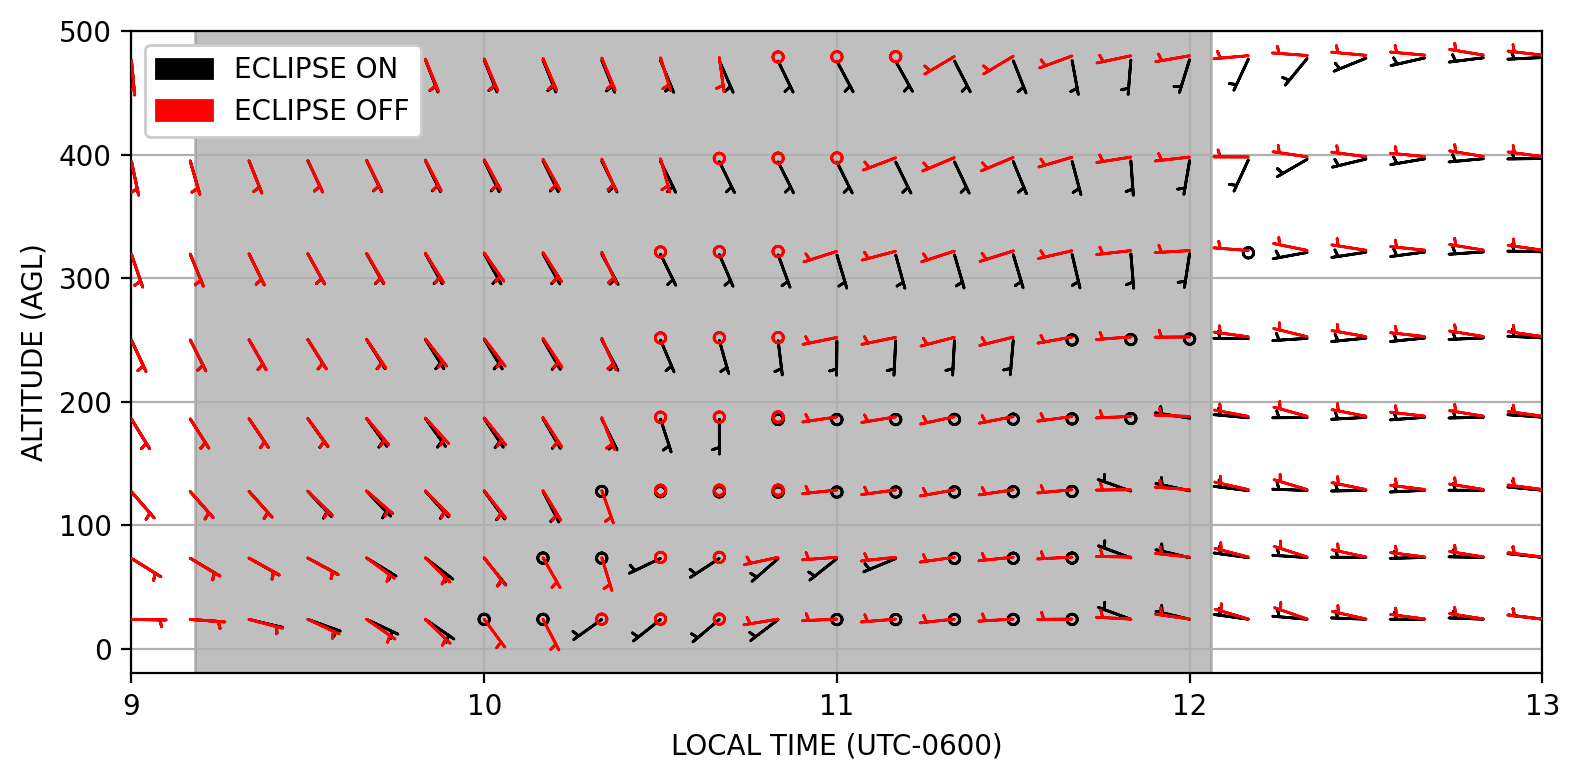

In [29]:
sfc_alt = hgt_pcc
skip = 1
fig = plt.figure(figsize=(8,4),dpi=200)
ax = plt.subplot(1,1,1)
ax.barbs(hours[::skip],(ze_pcc-sfc_alt)[inds][::skip],ue_pcc[inds][::skip],ve_pcc[inds][::skip],length=5,zorder=9,label="ECLIPSE ON")
ax.barbs(hours[::skip],(zne_pcc-sfc_alt)[inds][::skip],une_pcc[inds][::skip],vne_pcc[inds][::skip],length=5,color='r',zorder=9,label="ECLIPSE OFF")

ax.axvspan(9.18,12.06,0,360,color='gray',alpha=0.5)
skip=1
#plt.plot(hours[::skip],shift_alt_e[::skip]-sfc_alt,color='k')
#plt.plot(hours[::skip],shift_alt_ne[::skip]-sfc_alt,color='r')
plt.ylim([-20,500])
ax.set_xticks(range(16))
plt.xlim([9,13])
plt.xlabel('LOCAL TIME (UTC-0600)')
plt.ylabel('ALTITUDE (AGL)')
plt.grid()
plt.legend(loc="upper left",framealpha=1).set_zorder(10)

fig.tight_layout()
plt.savefig("wrf_soundings_14.png",bbox_inches='tight')